# Introduction

This notebbok explores data sourced from: 

- The [iNaturalist Licensed Observation Images](https://registry.opendata.aws/inaturalist-open-data/) dataset which is available as open data in and AWS S3 bucket. 
- The [IUCN Red List of Threatened Species spatial data](https://www.iucnredlist.org/resources/spatial-data-download)

The scope of this project is to look at observations for Amphibians from iNaturalist and compare this to the IUCN geospatial data and IUCN Red List category. 


In [109]:
# Install Packages
!pip install matplotlib
import pandas as pd
import geopandas as gpd
import awswrangler as wr
import datetime 
from IPython.display import Image
import matplotlib.pyplot as plt

  Using cached matplotlib-3.5.1-cp38-cp38-macosx_10_9_x86_64.whl (7.3 MB)
     |████████████████████████████████| 895 kB 10.3 MB/s eta 0:00:01
  Using cached kiwisolver-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl (61 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     |████████████████████████████████| 3.0 MB 16.5 MB/s eta 0:00:01
You should consider upgrading via the '/Users/jess_hitchcock/Repos/inaturalist-analysis/.venv/bin/python3 -m pip install --upgrade pip' command.


## iNaturalist Licensed Observation Image Data
This dataset is comprised of the following files: 
- Taxa - a comprehensive list of taxon_ids for living organism observations
- Observers - data about the user who made each observation
- Observations - A record of individual observations of living organisms
- Photos - photographs of observations 

Information about the available data can be found [in the iNaturalist Open Data GitHub repository](https://github.com/inaturalist/inaturalist-open-data).

The image below shows the data model ([source](https://github.com/inaturalist/inaturalist-open-data))

![iNaturalist Licensed Observation Images, sourced from "https://github.com/inaturalist/inaturalist-open-data"](images/inaturalist_open_data.png)


For the purposes of this project we are only interested in the metadata files: 
- Taxa
- Observers
- Observations

### iNaturalist Observation Data Exploration

#### Step 1: Load the files from S3  

In [30]:
observations = wr.s3.read_csv('s3://inaturalist-open-data/observations.csv.gz', compression='gzip', sep='\t')

In [25]:
observers = wr.s3.read_csv('s3://inaturalist-open-data/observers.csv.gz', compression='gzip', sep='\t')

In [27]:
taxa = wr.s3.read_csv('s3://inaturalist-open-data/taxa.csv.gz', compression='gzip', sep='\t')

#### Step 2: Preview the data

##### Taxa
This table consists of the following fields: 
- taxon_id: iNaturalist taxon identifier
- ancestry: sequence of taxon_ids showing the ancestry of the taxon record
- rank_level: a value used for ordering taxonomic groups 
- rank: the taxonomic group 
- name: scientific name 
- active: indicator of whether the taxon is active or not 

A taxonomic category or group, such as a phylum, order, family, genus, or species. 
This image shows some of the groups involved in a taxonomy hierachy ([source](https://en.wikipedia.org/wiki/Taxonomic_rank#/media/File:Taxonomic_Rank_Graph.svg)):

In [105]:
Image(url= "images/Taxonomic_Rank_Graph.svg.png", width=400, height=400)

In [42]:
# determine the records in the taxa dataset 
len(taxa)

1311565

In [43]:
# preview the fields
taxa.head(5)

,taxon_id,ancestry,rank_level,rank,name,active
0,9318,48460/1/2/355675/3/7251/11989/9315,10.0,species,Icterus parisorum,True
1,8943,48460/1/2/355675/3/7251/980017,20.0,genus,Calyptura,True
2,5416,48460/1/2/355675/3/71261/5067/5414,10.0,species,Ictinia mississippiensis,True
3,7182,48460/1/2/355675/3/6888/6912/7181,10.0,species,Amazonetta brasiliensis,True
4,6584,48460/1/2/355675/3/67573/6544/6556,10.0,species,Chaetura spinicaudus,True


In [45]:
# identify the taxon for ampbihia 
taxa[taxa['name'] == 'Amphibia']

,taxon_id,ancestry,rank_level,rank,name,active
11357,20978,48460/1/2/355675,50.0,class,Amphibia,True


In [63]:
# return active amphibia species records  
taxa.dropna(subset=['ancestry'], inplace=True)
amphibia_taxa = taxa[taxa.ancestry.str.contains('20978', case=False)]
active_amphibian_species = amphibia_taxa[(amphibia_taxa['rank'] == 'species') & (amphibia_taxa['active'] == True)]
active_amphibian_species

,taxon_id,ancestry,rank_level,rank,name,active
10166,25078,48460/1/2/355675/20978/20979/24736/787573/25077,10.0,species,Gastrophryne carolinensis,True
10172,27116,48460/1/2/355675/20978/26718/26909/787564/27087,10.0,species,Eurycea junaluska,True
10176,24379,48460/1/2/355675/20978/20979/23540/787584/24374,10.0,species,Osteopilus dominicensis,True
10179,24169,48460/1/2/355675/20978/20979/64737/787580/24126,10.0,species,Gastrotheca fissipes,True
10183,27403,48460/1/2/355675/20978/26718/26909/787551/27380,10.0,species,Desmognathus folkertsi,True
...,...,...,...,...,...,...
1272938,1304878,48460/1/2/355675/20978/20979/25473/25474,10.0,species,Rana wuyiensis,True
1272939,1304882,48460/1/2/355675/20978/20979/787531/25222/25239,10.0,species,Assa wollumbin,True
1272940,1304880,48460/1/2/355675/20978/20979/24601/991960/24719,10.0,species,Leptobrachella purpura,True
1272941,1304879,48460/1/2/355675/20978/20979/24736/787567/25178,10.0,species,Micryletta menglienica,True


In [97]:
amphibian_species_taxons = list(active_amphibian_species['taxon_id'].astype(int))

**Taxon Ancestry** 

The `ancestry` field is complex in that the taxon ranks included can be different for different taxon_ids. 
Some species, for example, may be associated with a class and subclass groups while another is only associated with a class. This means that the if we read the ancestry field from left to right we can't be sure what taxon rank is at each position. 

In order to easily aggregate our data we will need to split out the ancestry field to enable reporting at different taxon rank levels e.g. if we want to know how many species are associated with the class Amphibia we would need an easy way to identify species associated with this class. 

In [101]:
# find distinct taxonomy ranks 
taxa['rank'].unique()

array(['species', 'genus', 'family', 'order', 'phylum', 'kingdom',
       'class', 'subspecies', 'complex', 'variety', 'form', 'hybrid',
       'subgenus', 'subtribe', 'suborder', 'superfamily', 'subfamily',
       'infraclass', 'subclass', 'tribe', 'superorder', 'zoosubsection',
       'subphylum', 'zoosection', 'infraorder', 'section', 'epifamily',
       'genushybrid', 'supertribe', 'parvorder', 'subkingdom',
       'subterclass', 'infrahybrid', 'superclass', 'subsection'],
      dtype=object)

##### Observations data
The observations data includes the following: 
- A unique identifier for the observation 
- observer_id - identifier for the observer this will correspond to the observer_id in the observers table 
- co-oridinates of the observation 
- positional accuracy in metres (this tells us how confident we are that the location  of the observation)
- taxon_id: the id of the taxon on iNaturalist (note a taxon is a taxonomic category or group, such as a phylum, order, family, genus, or species).
- quality grade: e.g. three possible values: research_grade, needs_id and casual
- observed_on: the date of the observation 

In [ ]:
# Determine the total number of observations 
len(observations)

In [ ]:
# Preview the first few lines of data
observations.head(5)

In [ ]:
# Look at the different quality types
observations['quality_grade'].unique()

In [98]:
# Count observation_records for amphibian species 
observations.dropna(subset=['taxon_id'], inplace=True)
observations['taxon_id'] = observations['taxon_id'].astype(int)
observations[observations['taxon_id'].isin([amphibian_species_taxons])]

,observation_uuid,observer_id,latitude,longitude,positional_accuracy,taxon_id,quality_grade,observed_on


##### Observers data
The observers data includes the following fields: 
- oberver_id: identifier for the user who made the observation 
- login: user's login name
- name: user's name

In some cases we need to be careful with sharing user data, however, this data was sourced from an open dataset which means that this user information is already in the public domain. 

In [99]:
# Determine the total number of observations 
len(observers)

448026

In [100]:
# Preview the first few lines of data
observers.head(5)

,observer_id,login,name
0,1,kueda,Ken-ichi Ueda
1,8,tueda,NaN
2,28,tiwane,Tony Iwane
3,85,russiannaturalistbrazil,NaN
4,129,field_daze,Liv MW


## IUCN Red List of Threatened Species Spatial Data
Users can download geospatial data for a range of living organisms from the IUCN Red List [website](https://www.iucnredlist.org/resources/spatial-data-download). 

Within the geospatial data, the IUCN Red List also assigns species to a red list category corresponding to their conservation status. 

The conservation status or IUCN Red List category types can be viewed in the image below ([source](https://www.iucn.org/resources/conservation-tools/iucn-red-list-threatened-species)):
![IUCN Red List Categories](images/iucn_red_list_category.png)


For the purposes of this project I have focused on Amphibian data so have uploaded the spatial data to my own AWS S3 bucket (s3://inaturalist-bucket).

We can list the contents of the bucket by accessing it using the AWS CLI: 

In [29]:
!aws s3 ls s3://inaturalist-bucket

                           PRE amphibians/
2022-01-25 16:49:44     500986 iNat_Amphibian_Reference.csv


### GeoSpatial Data 

The IUCN Red List of Threatened Species Spatial Data comes in a shapefile format. 

Defintion of a [shapefile from Wikipedia](https://en.wikipedia.org/wiki/Shapefile)
>The shapefile format is a geospatial vector data format for geographic information system (GIS) software. 
>The shapefile format can spatially describe vector features: points, lines, and polygons, representing, for example, water wells, rivers, and lakes. Each item usually has attributes that describe it, such as name or temperature. 

Each shapefile refers to a collection of files with a common filename prefix, stored in the same directory. The three mandatory files have filename extensions .shp, .shx, and .dbf. The actual shapefile relates specifically to the .shp file, but alone is incomplete for distribution as the other supporting files are required.

Description of files associated with a shapefile: 
- .shp — the file that contains the geometry for all features 
- .shx — the file that indexes the geometry 
- .dbf — the file that stores feature attributes in tabular format 
- .prj - the file contains information on projection format including the coordinate system and projection information. It is a plain text file describing the projection using a well-known text (WKT) format 
- .sbn and .sbx the files that are spatial index of the features 
- .sahp.xml - the file that is the geospatial metadata in XML format

I referred to [this article](https://www.earthdatascience.org/workshops/gis-open-source-python/intro-vector-data-python) to get started with shapefiles in Python. 


### GeoSpatial Data Exploration
This geospatial file has records for different amphibian species. 
Some of the fields of interest include: 
- binomial: the scientific name for the species 
- compiler: who complied the geometry
- yrcompiled: when the distribution was compiled
- citation
- taxonomy infomration such as subspecies, subpop, order, family, genus
- category: the IUCN red list categorisation of the species
- marine: whether the species is a marine species or not 
- terrestrial: whether the species is a terrestrial species or not 
- freshwater: whether the species is found in freshwater 
- geometry in the form of a polygon 
- shape length and area of the geometry


In [26]:
# Step 1: Use GeoPandas to read in the shapefile from the s3 bucket. 
geospatial_data = gpd.read_file('s3://inaturalist-bucket/amphibians/amphibians.shp')

In [106]:
# preview the shapefile data 
geospatial_data.head(3)

,id_no,binomial,presence,origin,seasonal,compiler,yrcompiled,citation,subspecies,subpop,...,order_,family,genus,category,marine,terrestial,freshwater,SHAPE_Leng,SHAPE_Area,geometry
0,57264,Engystomops montubio,1,1,1,IUCN,2009,IUCN (International Union for Conservation of ...,None,None,...,ANURA,LEPTODACTYLIDAE,Engystomops,LC,false,true,true,5.755238,1.264393,"POLYGON ((-80.59473 -1.00518, -80.57579 -0.948..."
1,56133,Hyperolius ferreirai,1,1,1,IUCN,2014,IUCN (International Union for Conservation of ...,None,None,...,ANURA,HYPEROLIIDAE,Hyperolius,DD,false,true,true,0.420328,0.008667,"POLYGON ((14.72465 -9.07726, 14.71390 -9.08009..."
2,55856,Agalychnis medinae,4,1,1,Grisel Velasquez,2020,IUCN (International Union for the Conservation...,None,None,...,ANURA,PHYLLOMEDUSIDAE,Agalychnis,EN,false,true,true,0.370600,0.002628,"POLYGON ((-67.68359 10.33905, -67.69001 10.336..."


The total record count is 8798 but there are only 7204 species. 
Some species have multiple spatial geometry rows associated with them. 
This will need to be facored in when building the data model. 

In [113]:
# number of records 
len(geospatial_data)

8798

In [114]:
# number of unique records (species count) 
len(geospatial_data['binomial'].unique())

7204

Test plotting the geometry fields

<AxesSubplot:>

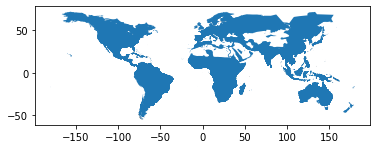

In [110]:
# Plot the geometries for the Amphibian order: Anura
geospatial_data[geospatial_data['order_']=='ANURA'].plot()

<AxesSubplot:>

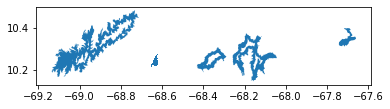

In [112]:
# Geospatial visualisation of the region in which the species Agalychnis medinae is found 
geospatial_data[geospatial_data['binomial']=="Agalychnis medinae"].plot()